<a href="https://colab.research.google.com/github/yinghuing/K_drama_recommender/blob/master/chapter5/implement_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: ハンズオンの準備
---

## 必要なライブラリのインストール

In [ ]:
# !pip install -q langchain langchain-openai langchain-community langchainhub langgraph tavily-python chromadb tiktoken

In [1]:
!pip install -q langchain==0.3.7 langchain-community==0.3.7 langchain-core==0.3.18 langchain-openai==0.2.9 langchain-text-splitters==0.3.2 langgraph==0.2.52 langgraph-checkpoint==2.0.5 langchainhub==0.1.21 tavily-python chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 880.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.7 MB/s eta 0:0

In [2]:
!pip freeze | grep langchain

langchain==0.3.7
langchain-community==0.3.7
langchain-core==0.3.18
langchain-openai==0.2.9
langchain-text-splitters==0.3.2
langchainhub==0.1.21


In [3]:
!pip freeze | grep langgraph

langgraph==0.2.52
langgraph-checkpoint==2.0.5
langgraph-sdk==0.1.57


## API キーの設定
*  左ナビゲーションで [**シークレット**] アイコン (鍵形のアイコン) をクリックします。
*  [**新しいシークレットを追加**] をクリックし、`LANGCHAIN_API_KEY`、`OPENAI_API_KEY`、`TAVILY_API_KEY` の 3 つを設定し、[**ノートブックからのアクセス**] を有効にします
  *  `OPENAI_API_KEY` の [**値**] には指定されたキーを入力します。
  *  `LANGCHAIN_API_KEY` と `TAVILY_API_KEY` の [**値**] にはご自身で取得したキーを入力してください。
*  入力が完了したら、下のセルを実行します。

In [6]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Section 1: LangGraph の基本
---
https://langchain-ai.github.io/langgraph/  
[Intro to LangGraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

## 基本のチャットボットを作成する

### State と Graph
State は `messages` (Message のリスト) として状態を保持する。  
[StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#stategraph)

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# State を定義
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# Graph (StateGraph) のインスタンスを作成
graph_builder = StateGraph(State)

### Node

In [8]:
from langchain_openai import ChatOpenAI

# Chat model を用意
model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Node を定義
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

# Node を Graph に追加
## 第 1 引数は Node の名前
## 第 2 引数は Node の関数/オブジェクト
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.set_entry_point("chatbot")

In [10]:
graph_builder.set_finish_point("chatbot")

### Graph のコンパイル

In [11]:
graph = graph_builder.compile()

### Graph の可視化

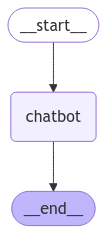

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Graph の実行

In [13]:
graph.invoke({"messages": [("user", "LangGraph とは何か教えてください。")]})

{'messages': [HumanMessage(content='LangGraph とは何か教えてください。', additional_kwargs={}, response_metadata={}, id='bf14dae0-c760-4979-8036-e78739bfbdc2'),
  AIMessage(content='LangGraphは、自然言語処理（NLP）や機械学習の分野で使用される技術やフレームワークの一つで、特に言語モデルやテキストデータの処理に関連しています。具体的には、LangGraphは言語の構造や意味をグラフ形式で表現し、テキストデータの分析や生成を行うための手法を提供します。\n\nLangGraphの主な特徴には以下のようなものがあります：\n\n1. **グラフ構造**: 言語の要素（単語、フレーズ、文など）をノードとして、これらの要素間の関係をエッジとして表現します。これにより、言語の構造を視覚的に理解しやすくなります。\n\n2. **意味的関係の把握**: グラフを用いることで、単語やフレーズの意味的な関係をより深く理解することが可能になります。例えば、同義語や対義語、関連語などの関係を明示化できます。\n\n3. **情報の統合**: 異なる情報源からのデータを統合し、より豊かな文脈を持つテキスト生成や分析が可能になります。\n\n4. **応用範囲**: LangGraphは、テキスト生成、要約、質問応答、感情分析など、さまざまなNLPタスクに応用できます。\n\n具体的な実装や使用例については、LangGraphに関連する研究やプロジェクトによって異なるため、興味がある場合は最新の文献やリソースを参照することをお勧めします。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 392, 'prompt_tokens': 17, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 

In [14]:
event = graph.invoke({"messages": [("user", "LangGraph とは何か教えてください。")]})
print(event["messages"][-1].content)

LangGraphは、自然言語処理（NLP）や機械学習の分野で使用される技術やフレームワークの一つで、特に言語データをグラフ構造で表現することに焦点を当てています。具体的には、言語の構造や意味をグラフとしてモデル化することで、より深い理解や解析を可能にすることを目的としています。

LangGraphの主な特徴には以下のようなものがあります：

1. **グラフ構造**: 言語の要素（単語、フレーズ、文など）をノードとして、これらの要素間の関係をエッジとして表現します。これにより、言語の構造を視覚的に理解しやすくなります。

2. **意味的関係の表現**: 単語やフレーズの意味的な関係をグラフで表現することで、文脈や関連性を考慮した解析が可能になります。

3. **情報検索や質問応答**: LangGraphを用いることで、情報検索や質問応答システムの精度を向上させることができます。グラフ構造を利用することで、関連情報を効率的に取得することができます。

4. **機械学習との統合**: LangGraphは、機械学習アルゴリズムと組み合わせることで、より高度な言語処理タスクに対応することができます。

LangGraphは、特に複雑な言語データの解析や処理において、従来の手法よりも優れたパフォーマンスを発揮する可能性があります。具体的な実装や応用例については、研究論文やプロジェクトのドキュメントを参照することが有益です。


In [15]:
import time
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "bye"]:
        print("Goodbye!")
        break

    event = graph.invoke({"messages": ("user", user_input)})
    print("Assistant:", event["messages"][-1].content)

User: luck of scorpio today
Assistant: I don't have real-time data or daily horoscopes, but I can provide a general idea of what Scorpios might expect based on typical astrological interpretations. Scorpios are often seen as passionate, resourceful, and determined individuals. 

For a typical day, Scorpios might focus on:

1. **Emotional Depth**: You may find yourself reflecting on your feelings and relationships. It's a good time to connect with loved ones or address any unresolved issues.

2. **Career Focus**: Your determination could lead to breakthroughs at work. Trust your instincts and be open to new opportunities.

3. **Health and Well-being**: Pay attention to your physical and mental health. Consider engaging in activities that promote relaxation and stress relief.

4. **Intuition**: Your intuition may be particularly strong today. Trust your gut feelings when making decisions.

For a more personalized reading, consider checking a reliable astrology website or app for today's 

## Tools
https://python.langchain.com/docs/concepts/#tools  
https://python.langchain.com/docs/how_to/#tools  
https://python.langchain.com/docs/integrations/tools/

### Tavily Search
*  Tool として Tavily Search を使用する。
*  この Tool は、インターネット検索をする機能を提供する。

[langchain_community.tools.tavily_search.tool.TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

# TavilySearchResults のインスタンスを作成
tool = TavilySearchResults(max_results=10)

# Tool のリストを作成
tools = [tool]

# Tool も Runnable であり invoke メソッドで実行できる
tool.invoke("LangGraph におけるノードとは何ですか。")

[{'url': 'https://qiita.com/ikedachin/items/2e7197ea87861247425f',
  'content': 'LangGraph は node と edge と state の理解が必要です。 node ：何かしら処理をするところ; state ： node で処理した内容を記憶した状態; edge'},
 {'url': 'https://note.com/astropomeai/n/ncabaf9c06a55',
  'content': '上流ノード：このノードの出力が次に何をするかを決定するために見られます。 関数：これは次にどのノードを呼び出すかを決定するために呼ばれます。文字列'},
 {'url': 'https://note.com/hatti8/n/n40bccb8bf662',
  'content': 'ツールノード（LLMを使わない処理ノードをツールノードと呼ぶ？）、エージェントをadd_nodeを使ってノードとして追加。 エッジ、条件付きエッジを追加する'},
 {'url': 'https://book.st-hakky.com/data-science/langgraph-intro/',
  'content': 'このページの見出し\n執筆者：Hakky社メンバー\nLangGraphとは？サンプルコードをもとにわかりやすく解説！\nはじめに\u200b\nこれまでの LangChain は一本の鎖のように A=>B=>C というように、処理が連続していて一方向にデータが流れていく構造でした。 LangGraph の登場によって簡単にサイクル（繰り返し循環する）を実装することができるようになりました。 LangChain についてはLangChain とは？各モジュールの機能と活用事例まとめやLangChain のエージェントについてで解説しています。\nLangGraph の全体像\u200b\nそれでは公式のサンプルに沿って実装しながら解説していきます。 公式ではTavilyという検索ツールを使って、学習データにない情報を取得して質問に答えるというサンプルが紹介されています。 完全なコードは公式のサンプルを参照してください。\n今回はこのような循環する二つのノードのグラフを作成

In [17]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# State を定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Graph (StateGraph) のインスタンスを作成
graph_builder = StateGraph(State)

# Chat model のインスタンスを作成
model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# 使用できる Tool の情報を Chat model 渡す
## 上で作成した Tool のリストをバインドする
llm_with_tools = model.bind_tools(tools)

# LLM を呼び出す Node を定義
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Node を Graph に追加
graph_builder.add_node("chatbot", chatbot)

### Tool で処理を実行する Node を追加する
ここでは、LangGraph に予め用意されている `ToolNode` を使用する。  
[ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)

In [18]:
from langgraph.prebuilt import ToolNode

# ToolNode のインスタンスを作成
## 上で作成した Tool のリストを渡す, can be more than one
tool_node = ToolNode(tools=[tool])

# Node を Graph に追加
graph_builder.add_node("tools", tool_node)

この Node のクラスは自分で定義することもできる。

In [ ]:
# import json
# from langchain_core.messages import ToolMessage

# class BasicToolNode:
#     """A node that runs the tools requested in the last AIMessage."""

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools}

#     def __call__(self, inputs: dict):
#         if messages := inputs.get("messages", []):
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call["name"]].invoke(
#                 tool_call["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call["name"],
#                     tool_call_id=tool_call["id"],
#                 )
#             )
#         return {"messages": outputs}

# tool_node = BasicToolNode(tools=[tool])
# graph_builder.add_node("tools", tool_node)

### Tool を使うかどうか条件分岐する Edge を追加する
ここでは、LangGraph にあらかじめ用意されている `tools_conditon` を使用する。  
[tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/?#tools_condition)

In [19]:
from langgraph.prebuilt import tools_condition

# Edge を Graph に追加
## Node "chatbot" の処理後に条件分岐を行う
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

この Edge のクラスは自分で定義することもできる。

In [ ]:
# from typing import Literal

# def route_tools(
#     state: State,
# ) -> Literal["tools", "__end__"]:
#     """Use in the conditional_edge to route to the ToolNode if the last message

#     has tool calls. Otherwise, route to the end."""
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return "__end__"

# # The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# # it is fine directly responding. This conditional routing defines the main agent loop.
# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", "__end__": "__end__"},
# )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("tools", "chatbot")

In [20]:
# tools → chatbot への Edge を追加
graph_builder.add_edge("tools", "chatbot")

# エントリーポイントをセット
graph_builder.set_entry_point("chatbot")

# Graph をコンパイル
graph = graph_builder.compile()

# end point auto set

### Graph を可視化

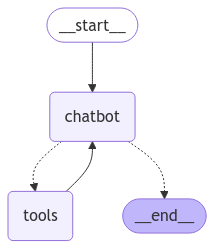

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Graph を実行

In [22]:
graph.invoke({"messages": [("user", "LangGraph におけるノードとは何ですか。")]})

{'messages': [HumanMessage(content='LangGraph におけるノードとは何ですか。', additional_kwargs={}, response_metadata={}, id='8879f59f-e2a2-49cc-be2a-eae2d7637494'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CYukC26o22OaQPlN6ySeifOy', 'function': {'arguments': '{"query":"LangGraph ノード"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 92, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf03fcb9-e260-45dc-b3d5-275ee2ef74c9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph ノード'}, 'id': 'call_CYukC26o22OaQPlN6ySeifOy', 'type

In [23]:
event = graph.invoke({"messages": [("user", "LangGraph におけるノードとは何ですか。")]})
print(event["messages"][-1].content)

LangGraphにおけるノード（Node）は、グラフ内の個々の処理の単位を表します。具体的には、ノードはPythonの関数（同期または非同期）であり、最初の引数として状態（state）を受け取り、オプションで2番目の引数として設定（config）を受け取ることができます。この関数は、状態を更新し、更新された状態を返します。

ノードは、以下のような役割を果たします：

1. **処理の実行**: ノードは特定のアクションを実行し、状態を変更します。例えば、チャットボットのノードは、ユーザーからのメッセージを受け取り、応答を生成することができます。

2. **状態の管理**: 各ノードは、他のノードと連携して状態を管理し、次のノードにメッセージを送信します。これにより、ノード間での情報の流れが確立されます。

3. **グラフの構成要素**: ノードは、LangGraphのグラフを構成する重要な要素であり、エッジ（Edge）と組み合わせて複雑なワークフローを作成することができます。

ノードは、状態を受け取り、処理を行い、結果を返すというシンプルな構造を持っているため、さまざまな処理を柔軟に組み合わせることが可能です。


インタラクティブに実行

In [24]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "bye"]:
        print("Goodbye!")
        break
    response = graph.invoke({"messages": [("user", user_input)]})
    print("Assistant:", response["messages"][-1].content)

User: what's scorpio luck today
Assistant: Today, October 3, 2023, Scorpio's luck is as follows:

- **Love Fortune**: 78
- **Fortune Index**: 68
- **Lucky Color**: Light yellow, orange, or blue
- **Lucky Number**: 8

For more details, you can check the full horoscope [here](https://en.mofalulu.com/Scorpio/luckday_20231003.html).
User: today is 2025/3/19
Assistant: Here are some notable news highlights from March 19, 2025:

1. **Bank of Japan Policy**: The Bank of Japan has decided to keep its policy rate unchanged as it assesses the impact of tariffs imposed by former President Trump. [Read more here](https://english.kyodonews.net/news/2025/03/b8fc3ce9e3ec-kyodo-news-digest-march-19-2025--1-.html).

2. **Massachusetts Legislative Visits**: Massachusetts legislators have visited Canadian renewable power operations, highlighting ongoing discussions about energy and health care systems in the state. [More details here](https://www.statehousenews.com/news/schedule/daily-advances---wednesda

### まとめたコード

In [25]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=5)
tools = [tool]
model = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tools = model.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

user_input = "LangGraph におけるノードとは何ですか。"

response = graph.invoke({"messages": [("user", user_input)]})
print("Answer:", response["messages"][-1].content)

Answer: LangGraphにおけるノードは、グラフ内の個々の処理を表す要素であり、通常はPythonの関数（同期または非同期）です。ノードは、最初の引数として状態（state）を受け取り、オプションで2番目の引数として設定（config）を受け取ります。この設定には、スレッドIDなどのオプションのパラメータが含まれることがあります。

ノードは、状態を受け取り、その状態を更新して返す役割を果たします。例えば、チャットボットのノードは、受け取ったメッセージを処理し、新しいメッセージを状態に追加することができます。ノードは、他のノードとの接続を定義するエッジを介して相互作用し、メッセージを送信して次のノードを実行させることができます。

要約すると、LangGraphのノードは、特定のアクションや処理を実行するための関数であり、状態を管理し、他のノードとの連携を通じて複雑なワークフローを構築するための基本的な構成要素です。


In [26]:
user_input = "こんにちはの英語は？"

response = graph.invoke({"messages": [("user", user_input)]})
print("Answer:", response["messages"][-1].content)

Answer: こんにちはの英語は「Hello」です。


# Section 2: チャットボットに会話履歴を追加する
---

## Checkpointer
* ここでは、インメモリに履歴データを保存する `MemorySaver` を使用する。
* データベースにデータを保存する場合は、`SqliteSaver` や `PostgresSaver` などを利用できる。
  
[MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#memorysaver)

In [27]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [28]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# State を定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Graph のインスタンスを作成
graph_builder = StateGraph(State)

# Tool の用意
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Chat model のインスタンスを作成
model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Chat model に Tool の情報を渡す
llm_with_tools = model.bind_tools(tools)

# Node と Edge の追加
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

## Checkpointer を指定して Graph をコンパイル

In [29]:
graph = graph_builder.compile(checkpointer=memory)

## Graph を可視化

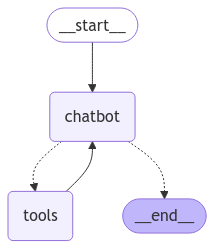

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Graph を実行

In [31]:
config = {"configurable": {"thread_id": "a678"}}

In [32]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "bye"]:
        print("Goodbye!")
        break
    response = graph.invoke({"messages": [("user", user_input)]}, config, stream_mode="values")
    print("Assistant:", response["messages"][-1].content)

User: what is the luck of scorpio horoscope on 2025/3/21.
Assistant: On March 21, 2025, Scorpio will experience a significant influence from Pluto, enhancing their ability to transform and reinvent various aspects of their life. This period is marked by opportunities for personal growth and change.

Additionally, the weekly horoscope for Scorpio from March 16 to 22, 2025, suggests that it is a good time to take on crucial tasks at work, which could lead to favorable outcomes in terms of health and wealth.

For more detailed insights, you can check the full horoscopes [here](https://gosta.media/en/horoscope-2025/horoscope-for-21-march-2025-for-all-zodiac-signs/) and [here](https://www.hindustantimes.com/astrology/horoscope/weekly-horoscope-scorpio-march-16-22-2025-predicts-good-health-and-wealth-101742042819789.html).
User: how about money luck
Assistant: On March 21, 2025, Scorpio's financial outlook will be characterized by a mix of opportunities and the need for cautious rebalancing.

# Section 3: LangGraph Adaptive RAG
---
https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/

## Index と Retiever を作成する
*  Documentloader には `WebBaseLoader` を使用
*  Text Splitter には `RecursiveCharacterTextSplitter` を使用
*  Embeddings model には `OpenAIEmbeddings` を使用
*  Vector store には `Chroma` を使用

In [33]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Embedding model を用意
embd = OpenAIEmbeddings(model='text-embedding-3-small', dimensions=1536)

# RAG 用にロードする Web サイトの URL を指定
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# ドキュメント (Web サイト) をロード
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# ドキュメントをチャンクに分割
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

# Vector store と Retriever を作成
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 10})

## LLM による各種の Chain を作成する

### question_router
ユーザーの入力について、Vector store に問い合わせるか Web 検索するか決定する

In [34]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
## ユーザークエリを最適なデータソースにルーティングするためのモデルを定義している。
## このモデルには、datasource という必須の属性があり、その値は "vectorstore" または "web_search" のいずれかでなければならない。
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# Chat model を用意
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Chat model に対して出力する形式を指定
## https://api.python.langchain.com/en/latest/chat_models/langchain_community.chat_models.openai.ChatOpenAI.html#langchain_community.chat_models.openai.ChatOpenAI.with_structured_output
structured_llm_router = model.with_structured_output(RouteQuery)

# Prompt template を作成
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
# Chain を定義
## この Chain はユーザーのクエリに対して、`datasource` の値として `vectorstore` か `web_search` を返す
question_router = route_prompt | structured_llm_router

動作を確認

In [35]:
print(
    question_router.invoke(
        {"question": "明日の東京の天気予報は何ですか。"}
    )
)
print(question_router.invoke({"question": "Agent の Memory とは何ですか。"}))

datasource='web_search'
datasource='vectorstore'


### retrieval_grader
Retriever が取得したドキュメントがユーザーの入力に対して関連のある適切なものか判定して "yes" か "no" を返す

In [36]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# Chat model を用意
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template を作成
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Chain を定義
retrieval_grader = grade_prompt | structured_llm_grader

動作を確認

In [37]:
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
len(docs)

binary_score='yes'


10

In [38]:
question = "fish memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
len(docs)

binary_score='no'


10

### rag_chain
Retriever または Web 検索 Tool によって取得したドキュメントを使用して、ユーザーの入力に対する回答を生成する

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt を用意
## https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=5416e3b5-a584-5319-ad04-ae41aaac8e2b
prompt = hub.pull("rlm/rag-prompt")

# Chat model を用意
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# Post-processing
# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | model | StrOutputParser()


動作を確認

In [ ]:
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

### hallucination_grader
`rag_chain` による回答がグラウンディングされている (ハルシネーションでない) ことを判定して `yes` か `no` を返す

In [ ]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# Chat model を用意
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = model.with_structured_output(GradeHallucinations)

# Prompt template を作成
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# Chain を定義
hallucination_grader = hallucination_prompt | structured_llm_grader

動作を確認

In [ ]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

### answer_grader
`rag_chain` による回答がユーザーに入力に対して適正である (関連している/解決している) ことを判定して `yes` か `no` を返す

In [ ]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# Chat model を用意
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = model.with_structured_output(GradeAnswer)

# Prompt template の作成
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# Chain を定義
answer_grader = answer_prompt | structured_llm_grader

動作を確認

In [ ]:
answer_grader.invoke({"question": question, "generation": generation})

### question_rewriter
`retrieval_grader` または `answer_grader` で `no` と判定された場合、適切な回答を得やすいようにユーザーの入力を書き直す

In [ ]:
# Chat model を用意
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt template を作成
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Chain を定義
question_rewriter = re_write_prompt | model | StrOutputParser()

動作を確認

In [ ]:
question_rewriter.invoke({"question": question})

## Web 検索のための Tool を用意する

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=5)

## State を定義する

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

## Graph のコンポーネントを定義する
ここまでに作った、Retriever、各種の Chain、Tool を使って、グラフにノードやエッジとして追加するための関数を定義していく

In [ ]:
from langchain.schema import Document

### Node ###

# Retriever を実行する関数
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


# 最終的に回答の生成を実行する関数
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


# Retriever によって取得されたドキュメントを評価する関数
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            # retriever が取得したドキュメントがユーザーの入力に関連性があれば、filtered_docs に追加する
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            # ドキュメントに関連性がなければ捨てる
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


# ユーザーの質問を書き直す関数
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


# Web 検索を実行する関数
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edge ###

# Vectore store の検索か Web 検索かを判定する関数
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    # question_router による判定の結果を返す
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


# 最終的な回答の生成を行うか判定する関数
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]


    if not filtered_documents:
        # grade_documents ですべてのドキュメントが関連性なしと判定された場合
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # grade_documents で関連性があると判定されたドキュメントがある場合
        print("---DECISION: GENERATE---")
        return "generate"


# 生成された回答が適切かを判定する関数
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # Generate の回答がハルシネーションでないことを判定する
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 回答がハルシネーションでなかった場合、回答が適正であることを判定する
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            # どちらの判定も "yes" だった場合
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            # 回答が適正でなかった場合
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        # 回答がハルシネーションと判定され場合
        return "not supported"

## Graph を構成する

In [ ]:
from langgraph.graph import StateGraph
from langgraph.constants import END

# Graph のインスタンスを作成
workflow = StateGraph(GraphState)

# Graph に Node を追加
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Graph に Edge を追加
workflow.set_conditional_entry_point(
    route_question,
    # route_question の出力に応じて次にどのノードに進むか分岐
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    # decide_to_generate の出力に応じて次にどのノードに進むか分岐
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    # grade_generation_v_documents_and_question の出力に応じて次にどのノードに進むか分岐
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Graph をコンパイル
app = workflow.compile()

## Graph を可視化

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## グラフを実行する

In [ ]:
# User Question
# inputs = {
#     "question": "プロンプトエンジニアリングの手法を3つ挙げてください。"
# }

inputs = {
    "question": "ももいろクローバーZのメンバーの名前を教えてください。"
}

value = {}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}': Done")
    print("---")

# Final generation
print(value["generation"])